In [4]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import kagglehub
import os
import keras


<h1>Classifying ASL alphabet images.</h1>
<h2>Goals of this notebook:</h2>
<ul>
<li>Load in data</li>
<li>Generate datasets for training and validation.</li>
<li>Make the model for classification.</li>
<li>Train model and check validation accuracy.</li>
</ul>

In [ ]:
# Download latest version of ASL images from Kaggle.
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Path to dataset files: /Users/loganridings/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


<h3>Make the datasets for training and validation.</h3>
<p>
Load the images using the keras.utils function. Split to 80% and 20% for training and validation.
</p>

In [ ]:
img_height = img_width = 200
batch_size = 50
train_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(path, 'asl_alphabet_train/asl_alphabet_train'),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  os.path.join(path, 'asl_alphabet_train/asl_alphabet_train'),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [ ]:
# Make a dictionary to look up the class names from the integer categories and vice versa.
classes = {class_name: i for i, class_name in enumerate(train_ds.class_names)}
def preprocess(x, y):
    print(y)
    return x, tf.one_hot(y, len(classes))
train_ds = train_ds.map(lambda x, y: preprocess(x, y))
val_ds = val_ds.map(lambda x, y: preprocess(x, y))
classes

Tensor("args_1:0", shape=(None,), dtype=int32)
Tensor("args_1:0", shape=(None,), dtype=int32)


{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

2025-03-18 11:58:10.566576: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


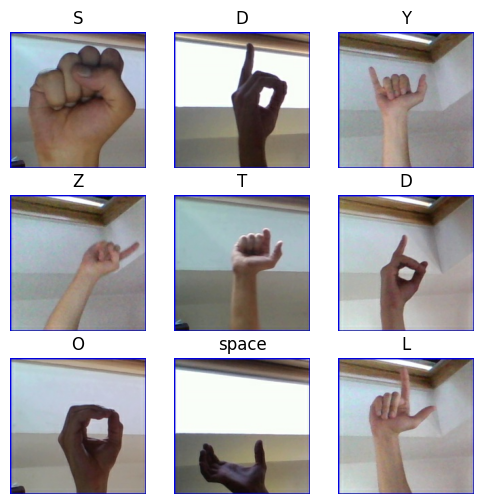

In [ ]:
# Show examples of the images in the dataset.
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy()[i].astype("uint8"))
    # inefficient way to reverse lookup but not important for this application
    im_class = next(key for key, value in classes.items() if value == np.argmax(labels[i]))
    plt.title(im_class)
    plt.axis("off")

In [ ]:
# Model generation function. Fairly deep CNN with max pooling layers in between to reduce dimensionality of final layers.
def make_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input((200,200,3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 2, activation='gelu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, 2, activation='gelu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, 2, activation='gelu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, 2, activation='gelu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(50, activation='gelu'),
        tf.keras.layers.Dense(29, activation='softmax'),
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'],
    )
    return model


model = make_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       193,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         1,479 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,929 (812.22 KB)

 Trainable params: 207,929 (812.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# prep data for slightly faster training
train_ds = train_ds.cache().shuffle(128).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(128).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Callback to stop the model from training as soon as the validation loss increases from one epoch to the next.
early_stopping = tf.keras.callbacks.EarlyStopping()

In [ ]:
# Fit the model to the training data, using callbacks defined above.
# model.fit(train_ds, validation_data = val_ds, epochs=10, callbacks=[early_stopping])
model = keras.saving.load_model('0_98_accuracy.keras')

In [18]:
model.evaluate(val_ds)

348/348 ━━━━━━━━━━━━━━━━━━━━ 52s 146ms/step - accuracy: 0.9808 - loss: 0.0598


[0.06116266921162605, 0.9805172681808472]

In [ ]:
# Make some sample predictions from the validation data. Stored in list of 3 tuples of img data, label (category int), and predicted label
data = [(img, label, model.predict([img], verbose=0)) for img, label in val_ds.take(1).as_numpy_iterator()]

/Users/loganridings/.local/share/virtualenvs/ASL_Classification-zp_clL6S/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_4
Received: inputs=('Tensor(shape=(32, 200, 200, 3))',)
  warnings.warn(msg)
/Users/loganridings/.local/share/virtualenvs/ASL_Classification-zp_clL6S/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_4
Received: inputs=('Tensor(shape=(None, 200, 200, 3))',)
  warnings.warn(msg)
2025-03-18 11:59:53.668183: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-18 12:02:28.304710: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


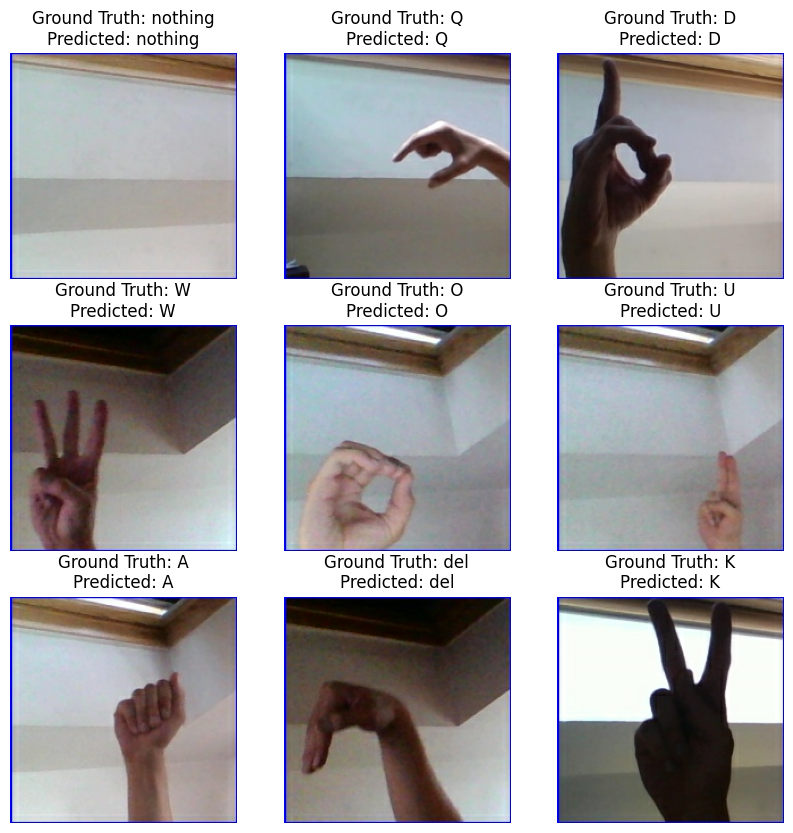

In [ ]:
plt.figure(figsize=(10, 10))
gridsize = 3
for images, labels in train_ds.take(1):
  for i in range(gridsize*gridsize):
    ax = plt.subplot(gridsize, gridsize, i + 1)
    plt.imshow(data[0][0][i].astype("uint8"))
    symbol = next(key for key, value in classes.items() if value == np.argmax(data[0][1][i]))
    prediction = data[0][2][i]
    prediction = next(key for key, value in classes.items() if value == np.argmax(prediction))
    plt.title('Ground Truth: ' + symbol + '\nPredicted: ' + prediction)
    plt.axis("off")
# plt.savefig('predictions.png', dpi=400)